# Welcome to the convoluted but effective way to disentangle the nucrossARF plot!

## Description
A description of how it works, what the steps are.

Steps:
1. Establish paths
    - Make a directory for intermidiate files
2. Generate a script to save information
3. Fit your crossarf script like you normally would. Bin the plot approximately to how you want the final plot to look.
    - Generate and enter a command to run the script that saves things.
    - Enter another command that saves the plotting information to recover the bins from.
4. Generate an ungrouped copy of all of the spectra.
5. Build a new script that uses the ungrouped spectra.
6. Load the final script into xspec.
    - Run the final xspec command to save the plotting information.
7. Make the plots.


## Establish some universal variables and paths:

In [145]:
import subprocess
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import xspec as xs
import numpy as np
import matplotlib.ticker as ticker


### CHANGE THESE ###
crossarf_dir = "/uufs/chpc.utah.edu/common/home/astro/wik/NuSTAR/zwcl1856/arf"#"/uufs/chpc.utah.edu/common/home/astro/wiplot/NuSTAR/Abell_665_Christian/newNewArftest"
obsids = ["70801003002"]#["70201002002", "70201003002"]
reg_base = "arf"#'newNewReg'
num_reg = 23#13
regs_to_include_in_plot = [8]#[3,8,9,10,11,12,13]
e_low = 3.0
e_high = 15.0
# regs_to_exclude_in_plot = [1,2,4,5,6,7]
# for k in range(14,23+1):
#     regs_to_exclude_in_plot.append(k)
# by default this is the path to the .xcm script, change if needed
crossarf_script = "/uufs/chpc.utah.edu/common/home/astro/wik/NuSTAR/zwcl1856/29MarchFitRelicPower.xcm" #f"{crossarf_dir}/{reg_base}.xcm"
#############



plotting_directory = f"{crossarf_dir}/Plotting_Stuff"

## Directory

In [ ]:
# Automatically make a directory to store intermediary files
plotting_directory = f"{crossarf_dir}/Plotting_Stuff"
subprocess.run(["mkdir", plotting_directory])
for obsid in obsids:
    subprocess.run(["mkdir", f"{plotting_directory}/{obsid}"])

## Generate Save Script
Run this to generate a .xcm script that will save the current script, model paramaters in a specific way, and the current binning that xspec uses.

In [39]:
# Could get away without saving the model pars but whatever maybe its nice
with open(f"{plotting_directory}/save_pars.xcm", "w") as file:
              
        lines = [
                # save paramaters
                f"set fileid [open {plotting_directory}/params.dat w]\n",
                f"for {{set i 1}} {{$i < {num_reg+1}}} {{incr i}} {{\n",
                " for {set k 1} {$k < 6} {incr k} {\n",
                "	    tclout param s$i:$k\n",
                "	    set s_val [string trim $xspec_tclout]\n",
                '	    puts $fileid "s$i:$k [lindex $s_val 0]"\n',
                " }\n",
                "}\n",
                "close $fileid\n",
                # save the script
                f"save all {plotting_directory}/script.xcm\n",
                # save the plot
                "setpl com rescale y\n",
                "pl\n",
                "iplot"
        ]
        file.writelines(lines)

## Interactive Step
Fit your spectra the normal way (running @cluster_dir/crossarf_dir/reg.xcm from NuSTAR directory in xspec).
Bin it up in such a way that you like because you're going to be stuck with it (everything will be binned based on how one set of spectra are binned in this plot)
Then run the script you generated above in xspec to save your final best-fit paramaters with the following commands that get generated below:

In [4]:
# Run this to generate xspec commands to run
print("Copy the following command and run it in xspec:\n")
print(f"@{plotting_directory}/save_pars.xcm")
print("\nThen run this one:\n")
print(f"wdata {plotting_directory}/original_plot.dat")

Copy the following command and run it in xspec:

@/uufs/chpc.utah.edu/common/home/astro/wik/NuSTAR/zwcl1856/arf/Plotting_Stuff/save_pars.xcm

Then run this one:

wdata /uufs/chpc.utah.edu/common/home/astro/wik/NuSTAR/zwcl1856/arf/Plotting_Stuff/original_plot.dat


## Ungrouped Spectra Generation
Now we need to make an ungrouped copy of all of the spectra.

In [ ]:
for obsid in obsids:

    os.chdir(f'{crossarf_dir}/{obsid}')
    
    dets = ['A', 'B']
    for det in dets:
        for reg in range(1,num_reg+1):
            spectrum = f'{reg_base}{det}{reg}.pha'
            out_spectrum = f'{plotting_directory}/{obsid}/{reg_base}{det}{reg}_g1.pha'

            hdul = fits.open(spectrum)

            data = hdul['SPECTRUM'].data
            grouping = data['GROUPING']

            for g in range(len(grouping)):
                grouping[g] = 1

            # save file
            hdul.writeto(out_spectrum, overwrite=True)
            print(f'Saved ungrouped spectrum: {out_spectrum}\n')

## New Plotting Script w/ Ungrouped Spectra
Now build a new .xcm script that includes the ungrouped spectra.

In [ ]:
####### ONLY RESCALE Y AND DEFINE ENERGY RANGE ABOVE!!!!!

script = f"{plotting_directory}/script.xcm"

# load in the saved script
lines = []
with open(script) as file:
    for line in file:
        lines.append(line)

# replace every data line with the new, ungrouped spectra path
dets = ["A", "B"]
for reg in range(1,num_reg+1):
    for det in dets:
        spectrum = f"{reg_base}{det}{reg}.pha\n"
        for idx,line in enumerate(lines):
            spec = line.split("/")[-1]
            if spec == spectrum:
                new_spectrum = f"{reg_base}{det}{reg}_g1.pha\n"
                data_number = line.split(" ")[1]
                obsid = line.split("/")[-2]
                new_line = f"data {data_number} {plotting_directory}/{obsid}/{new_spectrum}"
                lines[idx] = new_line

# add in plotting lines
plotting_lines = [
    "cpd /xs\n",
    "setpl e\n",
    "pl data\n",
    "setpl com rescale\n",
#    f"setpl com rescale x {e_low} {e_high}\n"
    "iplot\n"
    ]
for line in plotting_lines:
    lines.append(line)

# write the updated script
with open(f"{plotting_directory}/ungrouped.xcm", "w") as file:
    file.writelines(lines)

## Interactive Step
Run the script using the command below in an empty terminal to load the ungrouped version. As usual, run it in the NuSTAR directory. It will take a while to load... do it in on demand or something interactive.

In [134]:
# Generate command
print("Run this command in a terminal:")
print(f"xspec - {plotting_directory}/ungrouped.xcm")
print("\nOr if you're already in xspec:")
print(f"@{plotting_directory}/ungrouped.xcm")

Run this command in a terminal:
xspec - /uufs/chpc.utah.edu/common/home/astro/wik/NuSTAR/zwcl1856/arf/Plotting_Stuff/ungrouped.xcm

Or if you're already in xspec:
@/uufs/chpc.utah.edu/common/home/astro/wik/NuSTAR/zwcl1856/arf/Plotting_Stuff/ungrouped.xcm


## Interactive Step
Now run the final command to save the ungrouped plotting information with this generated command:

In [135]:
# Generate command
print("Run this command in xspec:")
print(f"wdata {plotting_directory}/ungrouped_plot.dat")

Run this command in xspec:
wdata /uufs/chpc.utah.edu/common/home/astro/wik/NuSTAR/zwcl1856/arf/Plotting_Stuff/ungrouped_plot.dat


## Plotting Data Size Check
Need to see if the plot files are too big and seperated lines. And if it did, reconfigure it.

In [143]:
def verifyScript(script):
    lines = []
    with open(f"{plotting_directory}/{script}.dat") as file:
        for _ in range(3): # Skip the first three lines
            next(file)

        for line in file:
            lines.append(line)

    new_lines = []
    idx = 0
    while idx <= len(lines)-1:
        line = lines[idx]
        if line.endswith("-\n"):
            top = line.split("-\n")[0]
            bottom = lines[idx+1].split("  ")[1]
            new_line = f"{top} {bottom}"
            new_lines.append(new_line)
            idx += 2
        else:
            new_lines.append(line)
            idx += 1

    with open(f"{plotting_directory}/{script}_verified.dat", "w") as file:
        file.writelines(new_lines)

verifyScript("ungrouped_plot")
#verifyScript("original_plot")

## Generate Bins
Generate a file that contains binning information for the plot (based on the intial plot)

In [87]:
original_plot_file = f"{plotting_directory}/original_plot_verified.dat"

# open up the original plotting information and save the bins from the first set of data
final_x_vals = []
final_x_errs = []

with open(original_plot_file, "r") as file: 
    data_sets = []
    current_set = []

    for _ in range(3):  # Skip the first three lines
        next(file)
    
    for line in file:
        row = line.split()
        if row[0] != "NO":
            current_set.append(row)
        else:
            data_sets.append(current_set)
            current_set = []
    data_sets.append(current_set)  # Append the last set

    for idx, set in enumerate(data_sets):
        if idx + 1 <= num_reg:
            x_vals = [float(row[0]) for row in set]
            x_errs = [(float(row[1]), float(row[1])) for row in set]
            final_x_vals.append(f"{x_vals}\n")
            final_x_errs.append(f"{x_errs}\n")

# save the bins and errors into two files
with open(f"{plotting_directory}/plot_bins.txt", "w") as file:
    file.writelines(final_x_vals)
with open(f"{plotting_directory}/plot_bins_errors.txt", "w") as file:
    file.writelines(final_x_errs)

## Plot Data vs Models
Now we have everything we need! We can make the plot now

[0.0016008652576288249, 0.0016008652576288249, 0.0016010352262468058, 0.0014926684793577494, 0.0015868573704182062, 0.0011774307693097298, 0.0009377280125188227, 0.0006934704983367321, 0.0005028287559259678, 0.00038939740099525185, 0.0002761204160171018, 0.00015815748676896687, 6.0123959490435414e-05]
2.999999996 4.679999824
4.67999959 7.19999957
7.20000029 10.84000063
10.84 15.0
2.999999996 4.679999824
4.67999959 7.19999957
7.20000029 10.84000063
10.84 15.0


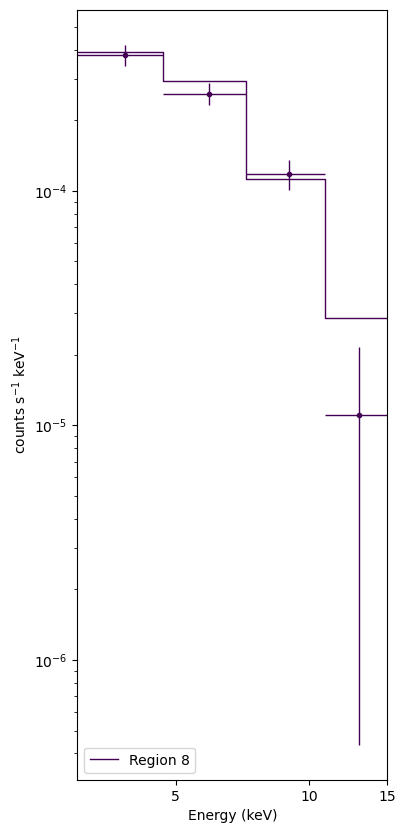

In [147]:
plot_file = f"{plotting_directory}/ungrouped_plot_verified.dat"


# Defining the plot things will be added to
plt.rcParams["figure.figsize"] = [4,10] 
fig, ax = plt.subplots(1,1)

# defining colors to use
cmap = plt.get_cmap("viridis")
colors = [cmap(i/(len(regs_to_include_in_plot))) for i in range(len(regs_to_include_in_plot))]

# Define bins from earlier
bins = []
bins_x_err = []
with open(f"{plotting_directory}/plot_bins.txt", "r") as file: 
    for line in file:
        one_set = eval(line) # technically there is a safer way to do this with ast
        bins.append(one_set)

with open(f"{plotting_directory}/plot_bins_errors.txt", "r") as file: 
    for line in file:
        one_set = eval(line)
        bins_x_err.append(one_set)

# Load data and seperate into sets sperated by NO NO NOs (will be in rows still)
data_sets = []
with open(plot_file, 'r') as file: 
    set = []
    for _ in range(3): # Skip the first three lines
        next(file)
    for line in file:
        row = [x for x in line.split()]
        if row[0] != "NO":
            set.append(row)
        else:
            data_sets.append(set)
            set = []
    data_sets.append(set)


# Plot the models
def plot_model(model,region_into,obs):
    # fromregion_intoregion, like 4_9, 4 into 9
    x = []
    y = []
    for row in data_sets[num_reg*obs+model-1]: 
        x_val = float(row[0])
        model_1_into = float(row[len(row) - 1 - (num_reg-region_into)])

        x.append(x_val)
        y.append(model_1_into)

    return(x,y)
    
def actually_plot(o):    
    all_models = [i for i in range(num_reg)]

    for reg in range(1,num_reg+1): # <- each plot
        all_obs_x = []
        all_obs_y = []
        w = 0
        for obs in range(0,len(obsids)*2): # <- each obs
            x_all_models = []
            y_all_models = []
            for reg_into in range(1,num_reg+1): # <- all regions in one plot plus one mysterious one or PERHAPS NOT IDK
            
                # get points
                x,y = plot_model(reg,reg_into,obs)

                # add all regions together for each observation
                if reg_into == 1:
                    y_all_models = y
                    all_obs_x.append(x)
                    x_all_models = x
                else:
                    for idx,y_ in enumerate(y_all_models):
                        y_all_models[idx] = y_ + y[idx]

                
                
            all_obs_y.append(y_all_models)
        
        
        # combine each obs, they all have the same binning now
        final_y = all_obs_y[o]#[sum(values) for values in zip(*all_obs_y)]


        # rebin the model so it matches
        model_y = final_y
        model_x = x_all_models

        # switch order around because the bins are messed up (data is already in right order from above)
        index_to_use = reg

        # new
        new_model_x = [a+b[0] for a,b in zip(bins[index_to_use-1],bins_x_err[index_to_use-1])] # this needs to be shifted over for it to plot right
        new_model_y = []

        # relevant x coords
        binned_x = bins[index_to_use-1]
        binned_x_err_individual = [a[0] for a in bins_x_err[index_to_use-1]]

        for idx,bin_x in enumerate(binned_x):
            error = binned_x_err_individual[idx]
            low_edge = bin_x - error
            high_edge = bin_x + error

            new_model_value = 0

            for mod_idx,mod_x in enumerate(model_x):
                
                if mod_x <= high_edge and mod_x >= low_edge:
                    new_model_value += model_y[mod_idx]*0.04 # since we are working with unbinned data?

            # if new_model_value == 0:
            #     print(binned_x)
            #     print(binned_x_err_individual)
            new_model_value = new_model_value / (error*2)
            new_model_y.append(new_model_value)

        # eliminate end of new_model_x and add something to the beginning
        new_model_x = new_model_x #[3.0] + new_model_x[:-1]
        new_model_y_to_plot = new_model_y#[new_model_y[0]] + new_model_y[:-1]
        
        all_models[reg-1] = (new_model_x,new_model_y_to_plot)


    # def doTheShifts():
    #     first_digits = []
    #     for m_idx,model in enumerate(all_models):
    #         for do_plot in regs_to_include_in_plot:
    #             if m_idx == do_plot-1:
    #                 y = model[1]
    #                 first_digits.append(y[0])

    #     shifts = [0]*num_reg
    #     for idx in range(1,len(first_digits)):
    #         shift = -50
            
    #         largest_val = first_digits[idx-1]
    #         next_val = first_digits[idx]
    #         difference = np.abs(np.log10(largest_val*10**shifts[idx-1])-np.log10(next_val*10**shift))

    #         while difference > 0.7:
    #             shift += 0.1
    #             difference = np.abs(np.log10(largest_val*10**shifts[idx-1])-np.log10(next_val*10**shift))

    #         shifts[idx] = shift
        
    #     return shifts

    # shifts = doTheShifts()

    # plot the models
    shift_idx = 0
    for idx,model in enumerate(all_models):
        x = model[0]
        y = model[1] 
        y.insert(0,y[0])
        x.insert(0,3)
        # shift = shifts[shift_idx]
        #y = list(np.array(y) * 10**shift)
        included = False
        for do_plot in regs_to_include_in_plot:
            if idx == do_plot-1:
                included = True
                shift_idx += 1
        if idx == 2:
            print(y)
        if included:
            if o == 0:
                ax.step(x,y,linewidth=1.0,color=colors[shift_idx-1], alpha=1.0, label=f"Region {regs_to_include_in_plot[shift_idx-1]}")
                #ax.scatter(x,y)
            else:
                ax.step(x,y,linewidth=1.0,color=colors[shift_idx-1], alpha=0.5)
                # x_max = max(x)
                # y_max = max(y)
                # y_min = min(y)
                # # print(shift)
                # # plt.annotate(fr"$\times$10$^{{{shift:.1f}}}$",
                # #      xy=(x_max, y_max),
                # #      xytext=(x[0] * 1.01, y_max*1.3),
                # #      ha='left', fontsize=6)
                # plt.annotate(f"Region {regs_to_include_in_plot[shift_idx-1]}",
                #     xy=(x_max, y_min),
                #     xytext=(e_high *1.02, y_min),
                #     fontsize=6)

actually_plot(0)
#actually_plot(1)




# plot all the data
def plot_data():
    
    all_collected = [i for i in range(num_reg)]
    for idxxx,k in enumerate(all_collected):
        obs_collected = [i for i in range(len(obsids)*2)]
        all_collected[idxxx] = obs_collected

    # for each region
    for idx,set in enumerate(data_sets):
        # grab all of the data (4 observations) for each region
        # all sets
        x_vals = []
        x_errs = []
        y_vals = []
        y_errs = []
        for row in set:
            # each individual set of data (each region for each obs)
            x_err = (float(row[1]),float(row[1]))
            x_val = float(row[0])

            y_val = float(row[2])
            y_err = (float(row[3]),float(row[3])) # symetrical errors here

            x_vals.append(x_val)
            x_errs.append(x_err)
            y_vals.append(y_val)
            y_errs.append(y_err)
  
        # the following are the individual observations
        obs_idx = (idx) // num_reg  # Determines which observation slot to fill
        reg_idx = (idx) % num_reg  # Determines the base index
        all_collected[reg_idx][obs_idx] = [x_vals, y_vals, x_errs, y_errs]
             

    all_binned = [i for i in range(num_reg)]
    for idxxx,k in enumerate(all_binned):
        obs_collected = [i for i in range(len(obsids)*2)]
        all_binned[idxxx] = obs_collected

    shift_idx = 0
    # for every obs:
    for obs in range(0,len(obsids)*2): 

        # for every region
        for model_idx,model in enumerate(all_collected):
            # add all channel values and errors together
            final_x = all_collected[model_idx][0][0] # just picking one to use
            final_x_err = all_collected[model_idx][0][2]
            final_y = model[obs][1] 
            final_y_err = model[obs][3] 
            # should just be the first set now


            # rebin the data so it matches the model binning
            model_y = final_y
            model_x = final_x

            plotting_idx = model_idx
            
            # new
            new_model_x = bins[model_idx] 
            new_model_y = []
            new_model_y_err = []
            new_model_x_err = bins_x_err[model_idx] 

            # relevant x coords
            binned_x = bins[model_idx]
            binned_x_err_individual = [a[0] for a in bins_x_err[model_idx]]

            for idx,bin_x in enumerate(binned_x):
                error = binned_x_err_individual[idx]
                low_edge = bin_x - error
                high_edge = bin_x + error

                new_model_value = 0

                if model_idx == 7:
                    print(low_edge, high_edge)

                squared_error_sum = 0
                for mod_idx,mod_x in enumerate(model_x):
                    if mod_x <= high_edge and mod_x >= low_edge:
                        new_model_value += model_y[mod_idx]*0.04 # since we are working with unbinned data
                        y_err = final_y_err[mod_idx][0]*0.04
                        squared_error_sum += y_err**2

                new_y_err = squared_error_sum**0.5 / (error*2)
                new_model_y_err.append((new_y_err,new_y_err))

                new_model_value = new_model_value / (error*2)
                new_model_y.append(new_model_value)


            all_binned[model_idx][obs] = [new_model_x, new_model_y, new_model_x_err, new_model_y_err]
            
  
    # add the binned data together
    for idx,reg in enumerate(all_binned):
        final_x = reg[0][0] # theyre all the same obs0,x
        final_x_err = reg[0][2]
        # final_y = [sum(max(0, val) for val in values) for values in zip(*[r[1] for r in reg])]
        final_y = [max(0, val) for val in reg[0][1]]
        final_y_err = reg[0][3]

        final_y_2 = [max(0, val) for val in reg[1][1]]
        final_y_err_2 = reg[1][3]

        

        # y_err_individuals = []
        # for obs in reg:
        #     yerr = obs[3]
        #     individual = []
        #     for err in yerr:
        #         one = err[0]
        #         individual.append(one)
        #     y_err_individuals.append(individual)
        
        #final_y_err = [(err*10**shifts[shift_idx], err*10**shifts[shift_idx]) for err in (np.sqrt(sum(a**2 for a in values)) for values in zip(*y_err_individuals))]
        #final_y = list(np.array(final_y)*10**shifts[shift_idx])
        # final_y_err = [(err, err) for err in (np.sqrt(sum(a**2 for a in values)) for values in zip(*y_err_individuals))]
        final_y = list(np.array(final_y))

        included = False
        for do_include in regs_to_include_in_plot:
            if idx == do_include -1:
                included = True
                shift_idx += 1
        if included:
            ax.errorbar(final_x,final_y,xerr=np.array(final_x_err).T,yerr=np.array(final_y_err).T,fmt='.',linewidth=1.0,color=colors[shift_idx-1])
            #ax.errorbar(final_x,final_y_2,xerr=np.array(final_x_err).T,yerr=np.array(final_y_err_2).T,fmt='.',linewidth=1.0,color=colors[shift_idx-1], alpha=0.5)

        # if idx == 7:
        #     print(final_y_err)
            


plot_data()




# plotting

for plot in range(0,1): # 0,13
    ax.set(yscale="log",xscale="log",xlabel='Energy (keV)',ylabel=r'counts s$^{-1}$ keV$^{-1}$',xlim=(e_low,e_high))
    #ax.plot((12.6,12.6), (0,1e-4))
  

#for a in ax.flat:
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))
ax.xaxis.set_major_locator(ticker.FixedLocator([5, 10, 15]))
ax.xaxis.set_minor_locator(ticker.NullLocator())  # Suppress minor ticks

#ax.set_ylim(1e-9,9e-2)

plt.legend(loc='lower left')

#plt.savefig(f'{plotting_directory}/crossArfFigureDataModels.pdf',bbox_inches='tight')



#plt.subplots_adjust(right=0.7)
plt.show()




## Plot Ratios

[0.0016008652576288249, 0.0016010352262468058, 0.0014926684793577494, 0.0015868573704182062, 0.0011774307693097298, 0.0009377280125188227, 0.0006934704983367321, 0.0005028287559259678, 0.00038939740099525185, 0.0002761204160171018, 0.00015815748676896687, 6.0123959490435414e-05]
[0.00039078964265299343, 0.00029263755197858805, 0.00011240935375139172, 2.8819414406608153e-05]
[0.0003805367257592363, 0.00025965060604484603, 0.00011803736233321345, 1.1048511471875e-05]


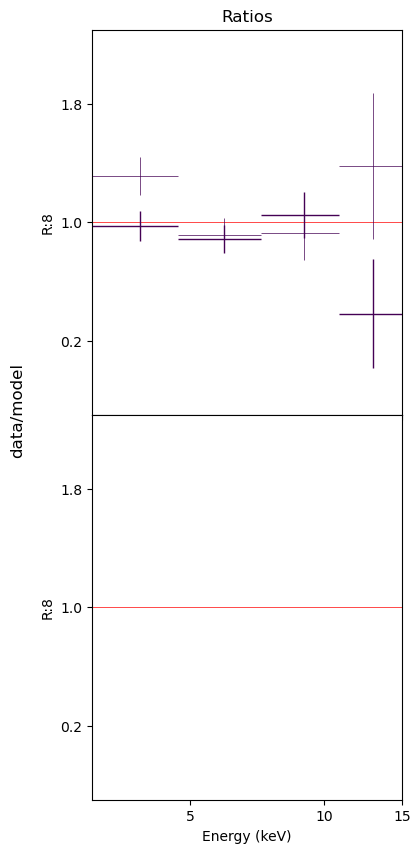

In [148]:
plot_file = f"{plotting_directory}/ungrouped_plot_verified.dat"

if len(regs_to_include_in_plot) == 1:
    regs_to_include_in_plot.append(regs_to_include_in_plot[0])

# Defining the plot things will be added to
plt.rcParams["figure.figsize"] = [4,10] 
fig, ax = plt.subplots(len(regs_to_include_in_plot),1,gridspec_kw={'hspace': 0},sharex=True)
#ld = ax[0]

# defining colors to use
cmap = plt.get_cmap("viridis")
colors = [cmap(i/(len(regs_to_include_in_plot))) for i in range(len(regs_to_include_in_plot))]

# Define bins from earlier
bins = []
bins_x_err = []
with open(f"{plotting_directory}/plot_bins.txt", "r") as file: 
    for line in file:
        one_set = eval(line) # technically there is a safer way to do this with ast
        bins.append(one_set)

with open(f"{plotting_directory}/plot_bins_errors.txt", "r") as file: 
    for line in file:
        one_set = eval(line)
        bins_x_err.append(one_set)

# Load data and seperate into sets sperated by NO NO NOs (will be in rows still)
data_sets = []
with open(plot_file, 'r') as file: 
    set = []
    for _ in range(3): # Skip the first three lines
        next(file)
    for line in file:
        row = [x for x in line.split()]
        if row[0] != "NO":
            set.append(row)
        else:
            data_sets.append(set)
            set = []
    data_sets.append(set)


# Plot the models
def plot_model(model,region_into,obs):
    # fromregion_intoregion, like 4_9, 4 into 9
    x = []
    y = []
    for row in data_sets[num_reg*obs+model-1]: 
        x_val = float(row[0])
        model_1_into = float(row[len(row) - 1 - (num_reg-region_into)])

        x.append(x_val)
        y.append(model_1_into)

    return(x,y)
    
all_models = [i for i in range(num_reg)]

for reg in range(1,num_reg+1): # <- each plot
    all_obs_x = []
    all_obs_y = []
    w = 0
    for obs in range(0,len(obsids)*2): # <- each obs
        x_all_models = []
        y_all_models = []
        for reg_into in range(1,num_reg+1): # <- all regions in one plot plus one mysterious one or PERHAPS NOT IDK
        
            # get points
            x,y = plot_model(reg,reg_into,obs)

            # add all regions together for each observation
            if reg_into == 1:
                y_all_models = y
                all_obs_x.append(x)
                x_all_models = x
            else:
                for idx,y_ in enumerate(y_all_models):
                    y_all_models[idx] = y_ + y[idx]
            
        all_obs_y.append(y_all_models)
    

    # combine each obs, they all have the same binning now
    final_y = all_obs_y[0] #[sum(values) for values in zip(*all_obs_y)]
    final_y_2 = all_obs_y[1]

    # rebin the model so it matches
    # old
    model_y = final_y
    model_y_2 = final_y_2
    model_x = x_all_models

    # switch order around because the bins are messed up (data is already in right order from above)
    index_to_use = reg

    # new
    new_model_x = [a+b[0] for a,b in zip(bins[index_to_use-1],bins_x_err[index_to_use-1])] # this needs to be shifted over for it to plot right
    new_model_y = []
    new_model_y_2 = []

    # relevant x coords
    binned_x = bins[index_to_use-1]
    binned_x_err_individual = [a[0] for a in bins_x_err[index_to_use-1]]


    for idx,bin_x in enumerate(binned_x):
        error = binned_x_err_individual[idx]
        low_edge = bin_x - error
        high_edge = bin_x + error

        new_model_value = 0
        new_model_value_2 = 0

        for mod_idx,mod_x in enumerate(model_x):
            if mod_x <= high_edge and mod_x >= low_edge:
                new_model_value += model_y[mod_idx]*0.04 # since we are working with unbinned data
                new_model_value_2 += model_y_2[mod_idx]*0.04 # since we are working with unbinned data

        new_model_value = new_model_value / (error*2)
        new_model_value_2 = new_model_value_2 / (error*2)
        new_model_y.append(new_model_value)
        new_model_y_2.append(new_model_value_2)


    # eliminate end of new_model_x and add something to the beginning
    #new_model_x = [3.0] + new_model_x[:-1]
    new_model_y_to_plot = new_model_y#[new_model_y[0]] + new_model_y[:-1]
    new_model_y_to_plot_2 = new_model_y_2 #[new_model_y_2[0]] + new_model_y_2[:-1]

    all_models[reg-1] = (new_model_x,new_model_y_to_plot,new_model_y_to_plot_2)


print(all_models[2][1])


# plot all the data
def plot_data():
    all_collected = [i for i in range(num_reg)]
    for idxxx,k in enumerate(all_collected):
        obs_collected = [i for i in range(len(obsids)*2)]
        all_collected[idxxx] = obs_collected

    # for each region
    for idx,set in enumerate(data_sets):
        # grab all of the data (4 observations) for each region
        # all sets
        x_vals = []
        x_errs = []
        y_vals = []
        y_errs = []
        for row in set:
            # each individual set of data (each region for each obs)
            x_err = (float(row[1]),float(row[1]))
            x_val = float(row[0])

            y_val = float(row[2])
            y_err = (float(row[3]),float(row[3])) # symetrical errors here? THIS IS THE BIGGEST CHANGE

            x_vals.append(x_val)
            x_errs.append(x_err)
            y_vals.append(y_val)
            y_errs.append(y_err)
  
        # the following are the individual observations
        obs_idx = (idx) // num_reg  # Determines which observation slot to fill
        reg_idx = (idx) % num_reg  # Determines the base index
        all_collected[reg_idx][obs_idx] = [x_vals, y_vals, x_errs, y_errs]
             

    all_binned = [i for i in range(num_reg)]
    for idxxx,k in enumerate(all_binned):
        obs_collected = [i for i in range(len(obsids)*2)]
        all_binned[idxxx] = obs_collected

    # for every obs:
    for obs in range(0,len(obsids)*2): 

        # for every region
        for model_idx,model in enumerate(all_collected):
            # add all channel values and errors together
            final_x = all_collected[model_idx][0][0] # just picking one to use
            final_x_err = all_collected[model_idx][0][2]
            final_y = model[obs][1] 
            final_y_err = model[obs][3] 
            # should just be the first set now


            # rebin the data so it matches the model binning
            # old
            model_y = final_y
            model_x = final_x

            plotting_idx = model_idx
            
            # new
            new_model_x = bins[model_idx] # # model_idx # this needs to be shifted over for it to plot right
            new_model_y = []
            new_model_y_err = []
            new_model_x_err = bins_x_err[model_idx] # just resave the bins better bud

            # relevant x coords
            binned_x = bins[model_idx]
            binned_x_err_individual = [a[0] for a in bins_x_err[model_idx]]


            for idx,bin_x in enumerate(binned_x):
                error = binned_x_err_individual[idx]
                low_edge = bin_x - error
                high_edge = bin_x + error

                new_model_value = 0

                squared_error_sum = 0
                for mod_idx,mod_x in enumerate(model_x):
                    if mod_x <= high_edge and mod_x >= low_edge:
                        new_model_value += model_y[mod_idx]*0.04 # since we are working with unbinned data
                        y_err = final_y_err[mod_idx][0]*0.04
                        squared_error_sum += y_err**2

                new_y_err = squared_error_sum**0.5 / (error*2)
                new_model_y_err.append((new_y_err,new_y_err))

                new_model_value = new_model_value / (error*2)
                new_model_y.append(new_model_value)


            all_binned[model_idx][obs] = [new_model_x, new_model_y, new_model_x_err, new_model_y_err]
            
  
    # add the binned data together and plot
    plot = 0
    for idx,reg in enumerate(all_binned):
        final_x = reg[0][0] # theyre all the same obs0,x
        final_x_err = reg[0][2]
        final_y = reg[0][1]#[sum(max(0, val) for val in values) for values in zip(*[r[1] for r in reg])]
        final_y_2 = reg[1][1]
        final_y_err = reg[0][3]#[]
        final_y_err_2 = reg[1][3]

        y_err_individuals = []
        for obs in reg:
            yerr = obs[3]
            individual = []
            for err in yerr:
                one = err[0]
                individual.append(one)
            y_err_individuals.append(individual)
        
        
        #final_y_err = [(err, err) for err in (np.sqrt(sum(a**2 for a in values)) for values in zip(*y_err_individuals))]

        #final_y_err_individual = [np.sqrt(a**2+b**2+c**2+d**2) for a,b,c,d in zip(y_err_individuals[0], y_err_individuals[1], y_err_individuals[2], y_err_individuals[3])]
        #final_y_err_individual = [np.sqrt(sum(err**2 for err in errors)) for errors in zip(*y_err_individuals)]
        
        final_y_err_individual = y_err_individuals[0]
        final_y_err_individual_2 = y_err_individuals[1]

        model = all_models[idx]
        model_x = model[0]
        model_y = model[1]
        model_y_2 = model[2]

        ratio_x = final_x
        ratio_xerr = final_x_err
        try:
            #ratio_yerr_2 = [(a,a) for a,b in zip(final_y_err_individual_2, model_y)]
            ratio_y = [a/b for a,b in zip(final_y, model_y)]
            ratio_y_2 = [a/b for a,b in zip(final_y_2, model_y_2)]
            ratio_yerr = [(a/b,a/b) for a,b in zip(final_y_err_individual, model_y)]
            ratio_yerr_2 = [(a/b,a/b) for a,b in zip(final_y_err_individual_2, model_y_2)]
        except:
            continue

        include = False
        for do_plot in regs_to_include_in_plot:
            if idx == do_plot - 1:
                include = True
        if include:
            print(model_y)
            print(final_y)
            # have to keep track of what plot youre on with some variable
            ax[plot].errorbar(ratio_x,ratio_y,xerr=np.array(ratio_xerr).T,yerr=np.array(ratio_yerr).T,fmt='none',linewidth=1.0,color=colors[plot],zorder=2)
            ax[plot].errorbar(ratio_x,ratio_y_2,xerr=np.array(ratio_xerr).T,yerr=np.array(ratio_yerr_2).T,fmt='none',linewidth=0.5,color=colors[plot],zorder=2)
            plot += 1


# plot line behind data
for plot in range(0,len(regs_to_include_in_plot)): # 0,13
    ax[plot].plot([0,30],[1,1], color='red', linewidth=0.5,zorder=1)


plot_data()




# plotting

for plot in range(0,len(regs_to_include_in_plot)): # 0,13
    ax[plot].set(yscale="linear",xscale="log",xlabel='Energy (keV)',ylabel=f'R:{regs_to_include_in_plot[plot]}',#ylim=(5e-7,50.0),xlim=(3,25))
        ylim=(-0.3,2.3),xlim=(3,15)) #ylim=(-0.001,0.001)
    #ax[plot].plot([0,30],[1,1], color='red', linewidth=1.0)
    ax[plot].set_yticks([0.2, 1.0, 1.8])

# Add a single y-axis label on the right (adjust position as needed)
fig.text(-0.08, 0.5, r'data/model', va='center', rotation=90, fontsize=12)


for a in ax:
    a.xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))
    a.xaxis.set_major_locator(ticker.FixedLocator([5, 10, 15]))
    a.xaxis.set_minor_locator(ticker.NullLocator())  # Suppress minor ticks

ax[0].set_title("Ratios")
plt.savefig(f'{plotting_directory}/crossArfFigureRatios.pdf',bbox_inches='tight')

plt.show()


